In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re,string
import nltk
import csv
import numpy as np
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [1]:
%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

2.2.0-rc1
/device:GPU:0
Num GPUs Available:  1
Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.561348525999989
GPU (s):
0.052401169999996
GPU speedup over CPU: 48x


In [2]:
#Download Dataset
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1sNLYkJvQ1S7I4VdymhhCHlp5VKqIfsvw' -O data.csv

#Download Slang-word Data
!wget --no-check-certificate 'https://drive.google.com/uc?id=1jSalMueFeq7VdegeBm8g1HUHkOJgPuif&export=download' -O kbba_lama.txt

#Download Stopword Data Indonesia
!wget --no-check-certificate 'https://drive.google.com/uc?id=119aA6cVGyhPCu5eZGkij2YNZeqqPsUud&export=download' -O stopword.txt

#Download rootword Indonesia
!wget --no-check-certificate 'https://drive.google.com/uc?id=1l-O1oPUnpYCxRBUV2FWzi-O5Nok45vX8&export=download' -O rootword.txt


--2020-03-29 15:01:29--  https://drive.google.com/uc?export=download&id=1sNLYkJvQ1S7I4VdymhhCHlp5VKqIfsvw
Resolving drive.google.com (drive.google.com)... 108.177.127.100, 108.177.127.101, 108.177.127.113, ...
Connecting to drive.google.com (drive.google.com)|108.177.127.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-1o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m6j9gjkgrgebkm2ccl18c1t49akiohmo/1585494075000/02672508490939035630/*/1sNLYkJvQ1S7I4VdymhhCHlp5VKqIfsvw?e=download [following]
--2020-03-29 15:01:30--  https://doc-04-1o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m6j9gjkgrgebkm2ccl18c1t49akiohmo/1585494075000/02672508490939035630/*/1sNLYkJvQ1S7I4VdymhhCHlp5VKqIfsvw?e=download
Resolving doc-04-1o-docs.googleusercontent.com (doc-04-1o-docs.googleusercontent.com)... 108.177.126.132, 2a00:1450:4013:c01::84
Connecting to doc-04-1o-docs.googleusercontent.com (d

In [0]:
!ls

#Read Data

In [8]:
import pandas as pd

data = pd.read_csv("data.csv", encoding='utf-8')
data.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,promo
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,promo
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",promo
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",promo
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,promo


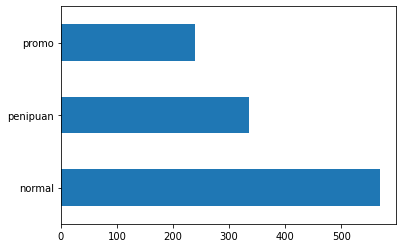

In [9]:
data['label'].value_counts().plot(kind='barh')

#Preproses Cleaning Data

In [0]:

kbba_lama = "kbba_lama.txt" #Slang word or acronym
rootword = "rootword.txt" #rootword
stopword = "stopword.txt" #stopword

def clean_tweet(tweet):   
    
    #Delete redundant word in data
    def hapus_katadouble(s):
        pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
        return  pattern.sub(r"\1\1", s)

    def tokenize(tweet):
        
        token = tweet.split(' ')
        return token
    #Change acronym or slang word into normal word in Indonesia
    def kbbi(tweet):
        global DATA_KBBI
        
        token = word_tokenize(tweet)
        #return token
        
        DATA_KBBI = [kamus.strip('\n').strip('\r') for kamus in open(kbba_lama)]
        dic={}
        for i in DATA_KBBI: 
            (key,val)=i.split('\t')
            dic[str(key)]=val
            
        tweet = ' '.join(str(dic.get(word, word)) for word in token).split()
        return tweet

    def normalize_token(_tokens):
        tokens = kbbi(_tokens)
        return tokens
        
    def prep(sent):
        tweet = normalize_token(sent)
        return tweet

    #Remove stopword
    def indo_stop(tweet):
        stop_words = [data.strip('\n') for data in open(stopword)]
        #stop_words = set(stopwords.words('indonesian'))
        word_tokens = tweet
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        filtered_sentence = []

        for w in word_tokens: 
            if w not in stop_words: 
                filtered_sentence.append(w)
        
        return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in filtered_sentence]).strip()

        #print(filtered_sentence)
  
    #pat1 = r'@[A-Za-z0-9]+'
    #pat2 = r'http\S+'
    #pat3 = r'href\S+'
    #combined_pat = r'|'.join((pat1, pat2, pat3 ))
    

    soup = BeautifulSoup(tweet, 'lxml')
    souped = soup.get_text()
    stripped = souped
    try:
        tweet = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        tweet = stripped
    
    unicode_literal = re.compile(r'\\u[0-9a-fA-F]{4}|\\U[0-9a-fA-F]{8}') #Remove hex, honestly for twitter but this also work in this case

    tweet = tweet.lower()
    tweet = re.sub(r"#(\w+)", ' ', tweet, flags=re.MULTILINE) #Remove Tag
    tweet = re.sub(r"@(\w+)", ' ', tweet, flags=re.MULTILINE) #Remove @
    tweet = re.sub(r'http.+', '', tweet, flags=re.S) #Remove link
    tweet = re.sub(r'href.+', '', tweet, flags=re.S) #Remove link but href
    tweet = unicode_literal.sub(r'', tweet)
    tweet = re.sub(r'".+', '', tweet, flags=re.S) #Remove "
    tweet = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet) #Double clean
    tweet = re.sub(r'\w*\d\w*', '',tweet).strip() #Removes number & str(angka)
    tweet = prep(tweet)
    tweet = indo_stop(tweet)
    tweet = hapus_katadouble(tweet)
    return ("".join(tweet))
    #tweet = prep(tweet)

In [11]:
#print(data["Teks"])
data_clean = []
labels = []

for i in data["Teks"]:
  data_clean.append(clean_tweet(i))

for f in data["label"]:
  labels.append(f)


print(len(data_clean[:]))
print(len(labels[:]))

1143
1143


#Hyperparameter

In [0]:
vocab_size = 1000
embedding_dim = 64
max_length = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_size = .2
SEED = 1000
num_epochs = 8



#Data Preparation

Split data into 2 groups, train and validation

In [13]:

from sklearn.model_selection import train_test_split

train_text, validation_text, train_labels, validation_labels = train_test_split(data_clean, labels, test_size=training_size, random_state=SEED)
#validation_labels, test_text, validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

#print(train_size)
print(len(train_text))
print(len(train_labels))
print(len(validation_text))
print(len(validation_labels))
"""
914
914
914
229
229
"""

914
914
229
229


'\n914\n914\n914\n229\n229\n'

Data Preprocessing using word_index

In [0]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

In [15]:
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'cek': 9,
 'com': 6,
 'hadiah': 7,
 'informasi': 2,
 'klik': 10,
 'nomor': 3,
 'pin': 5,
 'sms': 8,
 'ww': 4}

In [16]:
train_sequences = tokenizer.texts_to_sequences(train_text)
print(train_sequences[10])

[539, 44, 215, 7, 87, 48, 540, 541, 22, 1, 736, 294, 5, 2, 10, 4, 1, 74, 1]


In [0]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [18]:
validation_sequences = tokenizer.texts_to_sequences(validation_text)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

229
(229, 50)


In [19]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq.shape)

print(validation_label_seq.shape)

(914, 1)
(229, 1)


In [0]:
print(set(labels))

{'promo', 'penipuan', 'normal'}


#Check Original Data

In [20]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_text(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_text(train_padded[1]))
print('---')
print(train_text[1])

<OOV> <OOV> <OOV> google <OOV> <OOV> soal besok subuh harap cek iya ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
---
formatnya berantakan odp google sheet rapikan soal besok subuh harap cek iya


#Train Model

In [131]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    #tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 64)          64000     
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 128)               66048     
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 260       
Total params: 138,564
Trainable params: 138,564
Non-trainable params: 0
_________________________________________________________________


In [0]:
import tensorflow as tf

model.compile(loss=tf.losses.SparseCategoricalCrossentropy(), #sparse_categorical_crossentropy
              optimizer='adam', 
              metrics=['accuracy'],)

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint
modelName ="SMS_Fraud2.hdf5"
checkpoint = ModelCheckpoint(modelName, monitor='val_loss', verbose=1, save_best_only=True, mode='min',)

In [134]:
num_epochs = 8
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq), callbacks = [checkpoint])

Epoch 1/8
28/29 [===========================>..] - ETA: 0s - loss: 1.1213 - accuracy: 0.5268
Epoch 00001: val_loss improved from inf to 0.74532, saving model to SMS_Fraud2.hdf5
29/29 [==============================] - 1s 36ms/step - loss: 1.1132 - accuracy: 0.5284 - val_loss: 0.7453 - val_accuracy: 0.6681
Epoch 2/8
26/29 [=========================>....] - ETA: 0s - loss: 0.5988 - accuracy: 0.7536
Epoch 00002: val_loss improved from 0.74532 to 0.44404, saving model to SMS_Fraud2.hdf5
29/29 [==============================] - 0s 11ms/step - loss: 0.6014 - accuracy: 0.7560 - val_loss: 0.4440 - val_accuracy: 0.8035
Epoch 3/8
27/29 [==========================>...] - ETA: 0s - loss: 0.3405 - accuracy: 0.9005
Epoch 00003: val_loss improved from 0.44404 to 0.26436, saving model to SMS_Fraud2.hdf5
29/29 [==============================] - 0s 11ms/step - loss: 0.3286 - accuracy: 0.9037 - val_loss: 0.2644 - val_accuracy: 0.8865
Epoch 4/8
29/29 [==============================] - ETA: 0s - loss: 0.18

#Training Visualization

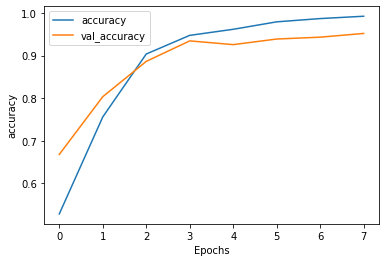

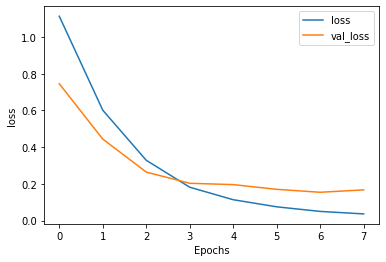

In [135]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#TEST

In [0]:
txt = ["Selamat dan sukses untuk Dies Natalis ke-55 Universitas Negeri Semarang. Bagi sedulur FMIPA, baik dosen, tenaga kependidikan, mahasisa dan alumni FMIPA UNNES mari ikuti doa serentak dalam rangka Dies Natalis ke-55 Lustrum UNNES yang akan diselenggarakan pada hari Senin, 30 Maret 2020 pukul 10.00 WIB secara daring"]

In [0]:
txt = ["Plgn Yth, selamat no Anda Resmi men-dpat Hadiah Rp.150jt Berkat isi ulang pulsa dari MOBOINDOSAT NO PIN;25e477r U/info klik; www.hadiahmoboindosat2017.com"]

In [0]:
txt = ["Mau ekstra telpon, SMS, Internetan (S&K berlaku)? Ikuti surveu singkat tentang aplikasi musik s/d  3 September. Klik: http://tsel.me/mulu"]

In [142]:
from tensorflow.keras.models import load_model

loadModel = load_model("SMS_Fraud2.hdf5")

In [146]:
labels = ['promo', 'penipuan', 'normal',]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = loadModel.predict(padded)

print(pred, labels[np.argmax(pred)])

[[4.4206943e-04 6.4826161e-01 3.1389514e-01 3.7401184e-02]] penipuan
